# New Narratives for old Buildings

---



Finding narratives through comparison of term frequency across countries

In [3]:
import os, re, csv
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from itertools import islice
from nltk.corpus import stopwords
import string
import pickle
import matplotlib.pyplot as plt

## Loading the dataset: heritage homes webistes


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
path = '/content/gdrive/MyDrive/CDA/' # working with google drive and colab

# path = 'datasets/' # working locally

In [6]:
# Country code: change here between 'NL' and 'UK'
cc_list = ['NL', 'UK', 'DE', 'FR']

In [7]:
# Import json data from Aipfy scraping into 4 separate dataframes
df_NL=pd.read_json(path+cc_list[0]+'_dataset_website-content-crawler.json') # NL
# select only two columns for analysis: url and text
df_NL=df_NL[['url','text']]

df_UK=pd.read_json(path+cc_list[1]+'_dataset_website-content-crawler.json') # UK
# select only two columns for analysis: url and text
df_UK=df_UK[['url','text']]

df_DE=pd.read_json(path+cc_list[2]+'_dataset_website-content-crawler.json') # DE
# select only two columns for analysis: url and text
df_DE=df_DE[['url','text']]

df_FR=pd.read_json(path+cc_list[3]+'_dataset_website-content-crawler.json') # FR
# select only two columns for analysis: url and text
df_FR=df_FR[['url','text']]

df_FR.head()

,url,text
0,https://www.chateau-combourg.com/privatisation,Events — COMBOURG\nLe château et le parc peuve...
1,https://www.chateau-combourg.com/chateaubriand,Chateaubriand — COMBOURG\nFrançois-René de Cha...
2,https://www.chateau-combourg.com/prixlitteraire,Prix Littéraire — COMBOURG\nLe Prix Combourg-C...
3,https://www.chateau-combourg.com/contact,Contact — COMBOURG\nNom(obligatoire)\nPrénom\n...
4,https://www.suscinio.fr/,Château de Suscinio dans le Morbihan\nOuvert t...


In [8]:
# check if there are further datasets to add per country

!ls "$path" | grep "^UK_"

UK_dataset_website-content-crawler.json
UK_EH_dataset_website-content-crawler_2025-03-18_13-49-50-417.json
UK_PC_dataset_website-content-crawler_2025-03-11_12-28-08-810.json


In [9]:
# manually append additional datasets (based on previous step)
df_missing1 = pd.read_json(path+'/NL_LG_dataset_website-content-crawler_2025-02-06_09-40-33-880.json')
result = pd.concat([df_NL, df_missing1])

In [10]:
df_missing1 = pd.read_json(path+'/UK_EH_dataset_website-content-crawler_2025-03-18_13-49-50-417.json')
df_missing2 = pd.read_json(path+'/UK_PC_dataset_website-content-crawler_2025-03-11_12-28-08-810.json')
result = pd.concat([df_UK, df_missing1, df_missing2])

Join all pages from a domain to an entry in the analysis. To do this, add a new column which will contain only the main domain name.

In [11]:
# function to extract the main domain from the url in the dataset (ALL DOMAINS)
def extract_main_domain(url):
    if not isinstance(str(url), str):
        print('NOT VALID',url)
        return None
    match = re.findall('(?:\w+\.)*[\w\-]+\.\w*', str(url)) #'www\.?([^/]+)'
    return match[0].lstrip('www.') if match else None

In [12]:
# Add a new column 'domain' and fill it by applying the extract_main_domain function to the 'url' column

# first, create a mapping of dataframes which could be addressed in a loop
df_dict = {'0':df_NL, '1':df_UK, '2':df_DE, '3':df_FR}

# then, loop through the df_dict to update each dataframe
for k, v in df_dict.items():
  cc_column = cc_list[int(k[-1])]+' domains'
  cc = cc_list[int(k[-1])]
  # print(cc_column, cc)
  urls = pd.read_csv(path+'url_lists/'+cc_list[int(k[-1])]+'_urls.csv')[cc_column].values.tolist()
  domains = {extract_main_domain(url) for url in urls if extract_main_domain(url) is not None}
  matching_links = [link for link in v.url if extract_main_domain(link) in domains]
  # update the dataframe
  v['domain'] = v['url'].apply(extract_main_domain)

In [13]:
# check one of the dataframes
df_NL.head()

,url,text,domain
0,http://weldam.nl/,"Introduction - Weldam\nIntroduction\nWeldam, s...",eldam.nl
1,http://weldam.nl/nederlands.html,Nederlands - Weldam\nCopyright Landgoed Weldam...,eldam.nl
2,http://weldam.nl/nederlands/beginpagina/test-2...,Test 1.2 - Weldam\nCopyright Landgoed Weldam 2...,eldam.nl
3,https://www.huisdoorn.nl/,Ontdek de geschiedenis - Museum Huis Doorn\nDe...,huisdoorn.nl
4,https://www.museumdefundatie.nl/,Museum de FundatieTwitter Widget Iframe\nMuseu...,museumdefundatie.nl


## Compare term frequencies across corpora

In [14]:
# list terms to compare
activities = ['kind','spel','avontuur',
              'child','game','adventure',
              'kind', 'spiel', 'abenteuer',
              'enfant', 'jeu', 'aventure']
events = ['feest','bruiloft','bruid','bruidegom',
          'party','wedding','bride','groom',
          'party', 'hochzeit', 'braut', 'bräutigam',
          'fête', 'mariage', 'mariée', 'marié']
nobility = ['graaf','baron','hertog',
            'earl','baron','duke',
            'graf','baron','herzog',
            'compte','baron','duc']
culture = ['tentoonstelling','museum','tuin','park','collectie',
           'exhibition','museum','garden','park','collection',
           'ausstellung','museum','garten','park','sammlung',
           'exposition','musée','jardin','parc','collection']
styles = ['rococo', 'barok', 'renaissance', 'gotiek', # or gotisch
          'rococo', 'baroque', 'renaissance', 'gothic',
          'rokoko', 'barock', 'renaissance', 'gotik',
          'rococo', 'baroque', 'renaissance', 'gothique']

Create texts as 'documents' to count terms and perform tf-idf

In [96]:
# count term frequencies across four dataframes
list_to_count = events # replace with the name of a list of terms (above)
dataframes = [df_NL, df_UK, df_DE, df_FR] # list of dataframes
number_of_terms = int(len(list_to_count) / 4) # calculate the number of terms in 1 language

term_count_dict = {}
start, end = 0, number_of_terms
for i, df in enumerate(dataframes):
  term_count_values = []
  for term in list_to_count[start:end]:
    #print(term)
    term_count_column = sum([str(item).lower().count(term) for item in df['text'].tolist()])
    #print(int(term_count_column.sum()))
    term_count_values.append(int(term_count_column))
  start += number_of_terms
  end += number_of_terms
  term_count_dict[cc_list[i]] = term_count_values

term_count_dict

{'NL': [1401, 273, 335, 5],
 'UK': [701, 1944, 106, 57],
 'DE': [268, 592, 66, 3],
 'FR': [1040, 694, 21, 71]}

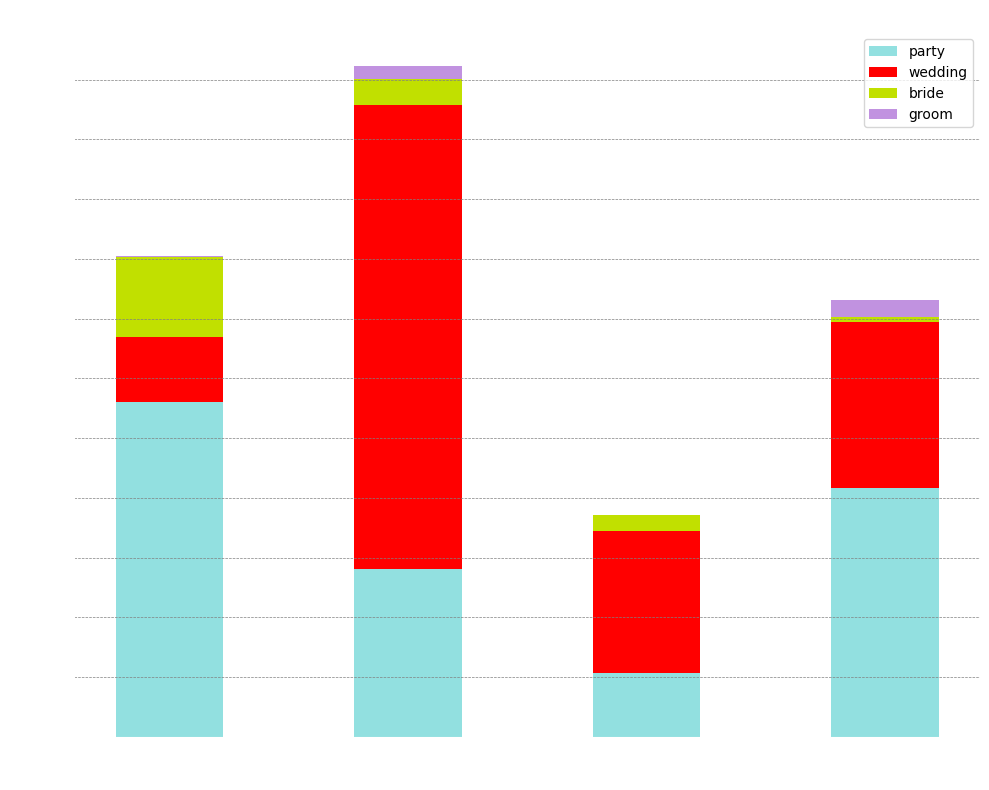

In [101]:
# Visualize the term count as a stacked bar chart per country
theme = 'parties'
terms = list_to_count[number_of_terms:number_of_terms*2] # change which section of the list is used in the legend
# Create a list of countries (y-axis labels)
countries = list(term_count_dict.keys())

# Create the stacked bar chart
width = 0.45  # Width of the bars

fig, ax = plt.subplots(figsize=(10,8))

bottom = np.zeros(len(countries))
colors = ['#92E0E0', 'red', '#C1E000', '#C192E0','#E05543','#E0C200']

# Add horizontal lines for values in the legend
for value in [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750]:
    #[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    #[250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750]
    #[100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
    #[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    #[2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000] # activities
    #[2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500] # arts & culture
  plt.axhline(y=value, color='grey', linestyle='--', linewidth=0.5)

for term_index in range(len(terms)):
    term_counts = [term_count_dict[country][term_index] for country in countries]
    ax.bar(countries, term_counts, width, label=terms[term_index], bottom=bottom,
           color=colors[term_index % len(colors)])
    bottom += np.array(term_counts)

ax.set_xlabel('Countries', color='white')
ax.set_ylabel('Term Counts', color='white')
ax.set_title('Terms related to '+theme+' per country', color='white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.legend()

plt.tight_layout()
plt.savefig(path+'outputs/2024_'+theme+'.png', transparent=True)
plt.show()

## Compare TF-IDF across corpora

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initiate separate corpora and compute step by step to not overflow the RAM
corpus_NL = df_NL['text'].dropna().tolist()
corpus_UK = df_UK['text'].dropna().tolist()
corpus_DE = df_DE['text'].dropna().tolist()
corpus_FR = df_FR['text'].dropna().tolist()

NameError: name 'df_NL' is not defined

In [1]:
# Calculate tf-idf scores for NL corpus

vectorizer_NL = TfidfVectorizer()
tfidf_matrix_NL = vectorizer_NL.fit_transform(corpus_NL)
feature_names_NL = vectorizer_NL.get_feature_names_out()
# Calculate TF-IDF scores for each term in each document
tfidf_scores_NL = tfidf_matrix_NL.toarray()

NameError: name 'TfidfVectorizer' is not defined

In [18]:
# Calculate tf-idf scores for UK corpus

vectorizer_UK = TfidfVectorizer()
tfidf_matrix_UK = vectorizer_UK.fit_transform(corpus_UK)
feature_names_UK = vectorizer_UK.get_feature_names_out()
# Calculate TF-IDF scores for each term in each document
tfidf_scores_UK = tfidf_matrix_UK.toarray()

In [19]:
# Calculate tf-idf scores for DE corpus

vectorizer_DE = TfidfVectorizer()
tfidf_matrix_DE = vectorizer_DE.fit_transform(corpus_DE)
feature_names_DE = vectorizer_DE.get_feature_names_out()
# Calculate TF-IDF scores for each term in each document
tfidf_scores_DE = tfidf_matrix_DE.toarray()

In [ ]:
# Calculate tf-idf scores for FR corpus

vectorizer_FR = TfidfVectorizer()
tfidf_matrix_FR = vectorizer_FR.fit_transform(corpus_FR)
feature_names_FR = vectorizer_FR.get_feature_names_out()
# Calculate TF-IDF scores for each term in each document
tfidf_scores_FR = tfidf_matrix_FR.toarray()

In [ ]:
term_to_find = "baron"

# Find the index of the term in the feature names
term_index = np.where(feature_names_FR == term_to_find)[0]

# If the term is found
if len(term_index) > 0:
  term_index = term_index[0]  # Get the index of the first occurrence
  tfidf_score = tfidf_scores_FR[0, term_index]
  print(f"TF-IDF score for '{term_to_find}' in the first document: {tfidf_score}")
else:
  print(f"Term '{term_to_find}' not found in the vocabulary.")


In [15]:
list_to_count = events # replace with the name of a list of terms (above)
corpora = [df_NL, df_UK, df_DE, df_FR] # list of dataframes
number_of_terms = int(len(list_to_count) / 4)

for term in list_to_count[:4]:
  print(term)

feest
bruiloft
bruid
bruidegom
